# Planning Graph Search

La planificación automatizada implica la creación de una secuencia de acciones para lograr un resultado deseado en un entorno dado. En esta libreta nuestro objetivo es emplear el algoritmo de búsqueda A*, mejorado por una heurística derivada del grafo de planificación, para encontrar planes óptimos para problemas de planificación. 

<center>
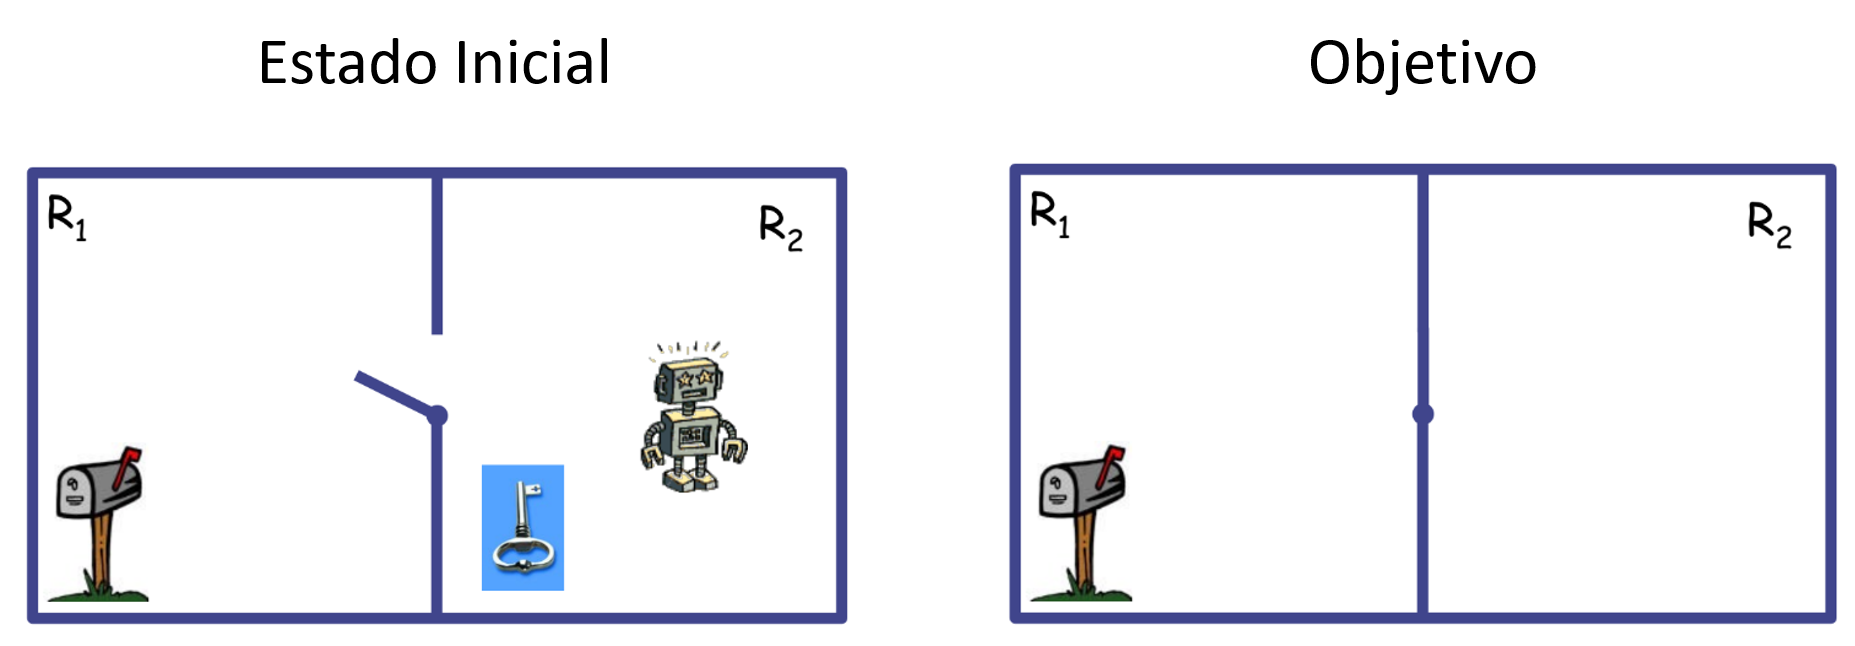
</center>

Primero importamos las librerias necesarias

In [33]:
import copy

## Representación

Definiremos la clase **Proposition** para almacenar las literales o estados del problema de planeación. 

Esta clase consta de 3 argumentos:

- Name: El cual nos indica el nombre del estado
- Argument: Donde se especifica el argumento del estado, o el objeto al cual está afectando
- Negation: Esta es una variable que nos indica si el estado es una negación

Además se definen algunos métodos especiales que nos ayudaran para el algoritmo:

- \_\_hash__ : Este método nos ayuda para poder usar este objeto en sets eg. set(\[Proposition1, Proposition2 ...\])
- \_\_invert__ : Con este método podemos definir la negación de la proposición. Este método se llama con el caracter"~".
- \_\_eq__ : Nos ayuda a establecer igualdades entre proposiciones.

In [34]:
class Proposition:
    def __init__(self, name, arg = '', negation = False):
        self.name = name
        self.argument = arg
        self.negation = negation
        
    def __hash__(self):
        return hash((self.name, self.argument, self.negation))
    
    def __eq__(self, other):
        return isinstance(other, Proposition) and self.name == other.name and self.argument == other.argument and self.negation == other.negation
    
    def __invert__(self):
        if self.negation:
            return Proposition(self.name, self.argument, False)
        else:
            return Proposition(self.name, self.argument, True)
    
    def __str__(self):
        if self.negation:
            return f'¬{self.name}({self.argument})'
        else:
            return f'{self.name}({self.argument})'

Con esto ya podemos generar el estado inicial del problema de la siguiente manera:

Iniciamos una lista donde añadiremos las proposiciones definidas a través de la clase correspondiente

In [35]:
initial_state = [Proposition('In', 'Robot, R2'), Proposition('In', 'Key, R2'), ~Proposition('Locked', 'Door')]

Para visualizarlo podemos llamar el método \_\_str__ definido en cada clase, y lo uniremos con el operador lógico ^

In [36]:
def print_state(state):
    return ' ^ '.join([str(x) for x in state])

In [37]:
print_state(initial_state)

'In(Robot, R2) ^ In(Key, R2) ^ ¬Locked(Door)'

Ahora definiremis una clase para almacenar las acciones aplicables a los estados. Esta clase va a tener los siguientes atributos:

- Name: Corresponde al nombre de la acción (Describe lo que hace)
- Preconditions: Es una lista con las precondiciones 
- Delete: Son las proposiciones que se borraran al momento de aplicar la acción
- Effect: Son las proposiciones que se agregaran al aplicar la acción
- Variants: Son las variantes de los efectos, en caso de que se necesiten

Esta clase tiene el método "Apply" que nos ayuda a poder aplicar la acción a un estado

In [38]:
class Action:
    def __init__(self, name, preconditions, delete, effect, variants = []):
        self.name = name
        self.preconditions = preconditions
        self.delete = delete
        self.effect = effect
        self.variants = variants
        
    def apply(self, state):
        # Hacemos una copia del estado actual
        state = copy.deepcopy(state)
        
        # Si existen variantes de los efectos
        if len(self.variants) > 0:
            for condition, variant_effect, variant_delete in self.variants:
                # Validamos que se cumplan todas las precondiciones en el estado actual
                if all(precondition in state for precondition in self.preconditions):
                    # Si la condición se cumple
                    if condition in state: 
                        # Aplicamos los efectos alternos
                        for element in variant_delete:
                            if element in state:
                                state.remove(element)
                        for element in variant_effect:
                            state.append(element)
                    else:
                        # Aplicamos efectos orginales
                        for element in self.delete:
                            if element in state:
                                state.remove(element)
                        for element in self.effect:
                            state.append(element)
        else:
            #Si se cumplen las precondiciones, aplicamos los efectos originales
            if all(precondition in state for precondition in self.preconditions):
                for element in self.delete:
                    if element in state:
                        state.remove(element)
                for element in self.effect:
                    state.append(element)
        return list(set(state))
    
    def __str__(self):
        return f'{self.name}'

A continuación definimos las acciones del problema:

In [39]:
grasp_key = Action(
    'Grasp Key', 
    [Proposition('In', 'Robot, R2'), Proposition('In', 'Key, R2')],            
    [], 
    [Proposition('Holding', 'Key')],
)

lock_door = Action(
    'Lock Door', 
    [Proposition('Holding', 'Key'), ~Proposition('Locked', 'Door')],
    [~Proposition('Locked', 'Door')],
    [Proposition('Locked', 'Door')],
)

key_into_box = Action(
    'Put Key Into Box',
    [Proposition('In', 'Robot, R1'), Proposition('In', 'Key, R1'), Proposition('Holding', 'Key')],
    [Proposition('Holding', 'Key'),  Proposition('In', 'Key, R1')],
    [Proposition('In', 'Key, Box')],
)

r1_to_r2 = Action(
    'Move from R1 to R2',
    [~Proposition('Locked', 'Door'), Proposition('In', 'Robot, R1')],
    [Proposition('In', 'Robot, R1')],
    [Proposition('In', 'Robot, R2')],
    [(Proposition('Holding', 'Key'), [Proposition('In', 'Robot, R2'), Proposition('In', 'Key, R2')], [Proposition('In', 'Robot, R1'), Proposition('In', 'Key, R1')])]
)

r2_to_r1 = Action(
    'Move from R2 to R1',
    [~Proposition('Locked', 'Door'), Proposition('In', 'Robot, R2')],
    [Proposition('In', 'Robot, R2')],
    [Proposition('In', 'Robot, R1')],
    [(Proposition('Holding', 'Key'), [Proposition('In', 'Robot, R1'), Proposition('In', 'Key, R1')], [Proposition('In', 'Robot, R2'), Proposition('In', 'Key, R2')])]
)

Ya que están definidas podemos aplicarlas llamando al método _"Apply"_, como se muestra en la siguiente celda:

In [40]:
print_state(grasp_key.apply(initial_state))

'In(Key, R2) ^ In(Robot, R2) ^ ¬Locked(Door) ^ Holding(Key)'

Lo que nos regresa es otro estado de proposiciones que corresponde al estado del mundo después de aplicar la acción

## Construcción del gráfico

Otra función muy importante en el algoritmo, es la función para construir la gráfica de planeación. Para esto usaremos un esquema relajado, donde no nos preocuparemos por acciones mutuamente excluyentos. Esto porque la función se usará varías veces para el cálculo de la herística, por lo tanto haría el algoritmo muy lento si se consideran estos escenarios.

In [41]:
def build_plan_graph(state, goal, actions):   
    # Iniciamos con el estado inicial en el nivel 0
    graph_levels = [state]
    
    i = 0
    while(True):
        # Definimos una lista para el nuevo estado con las proposiciones del estado anterior (representa acciones sin efecto)
        new_level = [*graph_levels[i]]
        
        # Aplicamos todas las acciones al estado actual y agregamos las nuevas proposiciones
        for action in actions:
            new_literals = action.apply(graph_levels[i])
            for lit in new_literals:
                new_level.append(lit)
                
        # Agregamos el nuevo nivel a la gráfica de planeación
        graph_levels.append(list(set(new_level)))
        
        # Si todos los elementos del estado objetivo están en el nuevo nivel recién creado, nos detenemos y regresamos el gráfico de planeación
        if all(elem in new_level for elem in goal):
            break
        
        # Si el tamaño de la lista no aumentó en los últimos niveles, regresamos una lista vacía (No hay solución)
        if len(list(set(new_level))) == len(graph_levels[i]):
            return []
            break
        
        i += 1
    
            
    return graph_levels
        
        

Para usar la función tendremos que definir un nodo objetivo, y una lista de acciones.

In [42]:
goal = [Proposition('Locked', 'Door'), Proposition('In', 'Key, Box')]

In [43]:
plan_graph_levels = build_plan_graph(initial_state, goal, [grasp_key, lock_door, key_into_box, r1_to_r2, r2_to_r1])

La salida son las proposiciones que podemos encontrar en cada nivel

In [44]:
i = 0
for level in plan_graph_levels:
    print('---------------------------------')
    print(f'LEVEL {i}')
    print(print_state(level))
    i += 1

---------------------------------
LEVEL 0
In(Robot, R2) ^ In(Key, R2) ^ ¬Locked(Door)
---------------------------------
LEVEL 1
Holding(Key) ^ ¬Locked(Door) ^ In(Robot, R1) ^ In(Robot, R2) ^ In(Key, R2)
---------------------------------
LEVEL 2
Holding(Key) ^ ¬Locked(Door) ^ In(Robot, R1) ^ In(Robot, R2) ^ Locked(Door) ^ In(Key, R1) ^ In(Key, R2)
---------------------------------
LEVEL 3
Holding(Key) ^ ¬Locked(Door) ^ In(Key, Box) ^ In(Robot, R1) ^ Locked(Door) ^ In(Key, R1) ^ In(Key, R2) ^ In(Robot, R2)


Esta gráfica nos orienta la búsqueda y es una aproximación optimista sobre la cantidad de pasos que nos tomaría llegar al objetivo. Por esto, usaremos la cantidad de niveles en la gráfica como heurística para orientar la búsqueda.

La función _graph_heuristic_ nos ayuda a hacer esto a partir de la gráfica de planeación. Donde regresa la cantidad de niveles expandidos hasta alcanzar el objetivo o nos regresa infinito si la gráfica no pudo encontrar el objetivo. 

In [45]:
def graph_heuristic(state, goal, actions):
    graph = build_plan_graph(state, goal, actions)
    if len(graph) > 0:
        return len(graph) - 1
    else:
        return float('inf')

## Búsqueda A*

Ya que tenemos las representaciones y la heurística podemos aplicar el algoritmo de A* para encontrar la solución.

Para esto lo primero que tenemos que hacer es contruir una clase Nodo, que nos ayudara a definir los estados de la búsqueda. Esta clase nodo tendrá los siguientes atributos:

- **State**: Corresponde al estado del mundo en el que se encuentra
- **Cost**: El costo acumulado para llegar a ese estado
- **Heuristic**: La heurística según se definió anteriormente
- **Function**: La función para orientar la búsqueda definida como costo + heurística
- **Plan**: El plan de acciones para llegar al estado del nodo

In [46]:
class Node:
    def __init__(self, state, cost, heuristic, plan):
        self.state = state
        self.cost = cost
        self.heuristic = heuristic
        self.function = cost + heuristic
        self.plan = plan

Definimos nuestro primer nodo con el estado inicial del problema

In [47]:
node = Node(initial_state, 0, float('inf'), [])

Y definimos una función para realizar la búsqueda A* basada en el algoritmo visto en clase

In [48]:
def A_star(initial_node, goal, actions):
    frontier = [initial_node]
    while len(frontier) > 0:
        node = frontier.pop(0)
        
        if all(elem in node.state for elem in goal):
            return node.plan
            break
            
        else:
            for action in actions:
                new_state = action.apply(node.state)
                   
                if all(elem in node.state for elem in new_state) and all(elem in new_state for elem in node.state) :
                    pass
                else:
                    h = graph_heuristic(new_state, goal, actions)
                    c = node.cost + 1
                    new_node = Node(new_state, c, h, copy.deepcopy(node.plan))
                    new_node.plan.append(action)
                    
                    frontier.append(new_node)
            
            frontier = sorted(frontier, key = lambda x: x.function)
            
    return 'NO HAY RESPUESTA'

Una vez con esto, podemos hacer llamar a la función para hacer la búsqueda

In [49]:
plan = A_star(node, goal, [grasp_key, lock_door, key_into_box, r1_to_r2, r2_to_r1])

In [50]:
plan = ' -> '.join([str(x) for x in plan])

In [51]:
plan

'Grasp Key -> Move from R2 to R1 -> Lock Door -> Put Key Into Box'